In [1]:
%load_ext autoreload
%autoreload 2

**Note:** This notebook requires high RAM if you are to run headless. To remain low memory, delete some data (such as don't use a new variable everytime you take a subset of data, for no repetition, etc). 

This VM runs on Azure STANDARD_NC6 instance (or equivalent).
- CPU: 6 cores
- RAM: 56 GB. 
- GPU: 1 K80.

In [2]:
from sklearn.datasets import fetch_20newsgroups
all_xs, all_y = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
                    shuffle=True, return_X_y=True)

In [3]:
def split_data(data, idx=None):
    """Split data for easier visualization. NOT FOR TRAINING."""
    if idx is not None: x = data[idx].split("\n")
    else: x = data.split("\n")
    x = list(filter(lambda a: a != '', x))
    return x

In [4]:
from fastai.text.all import *

There are a few cleanings we'll have to do. Normally, we need to lower all characters, but based on what one learns in fastai, there are things that trains better with capital letters. And when we pass through fastai tokenizer, it will lower it for us, and adding a `xxmaj` for us just before this. We'll discuss about this `xxmaj` later when we came to it. 

In [5]:
# Make sure to lower all characters. 
# all_xs = [g.lower() for g in all_xs]

assert len(all_xs) == len(all_y) == 18846

This step is optional. We can either use the whole dataset, or we choose a subset. Here, to speed up training, I use a subset. However, you could just tune this value to get the best results, or just use the whole dataset. 

The idea is this: it's not necessary all short sentence gives good results. So we only keep the longer articles and discard those that are one or two sentence long (about threshold=5). Here we did it for larger threshold to speed up training, but could be tuned again for better results. 

In [6]:
def threshold_subset(all_xs, threshold=10):
    """
    Will return a numpy array containing all the data that is to be kept.
    Threshold means the number of lines (after separated using `split_data`)
    for the data to be retained, inclusive. By default, threshold=10 means
    if data is less than 10 lines it will be discarded. 
    """
    to_keep = []
    for k, x in enumerate(all_xs):
        sentence_len = len(split_data(x))
        if sentence_len >= threshold: to_keep.append(k)

    return np.array(to_keep)

In [7]:
to_keep = threshold_subset(all_xs)

In [8]:
assert len(to_keep) == len(np.unique(to_keep))
len(to_keep), to_keep.max(), to_keep.min()

(8940, 18845, 2)

In [9]:
new_xs = np.array(all_xs)[to_keep]
new_y = np.array(all_y)[to_keep]

What we need to note for the `dls` functio below is that, we take in the **column name** from the `TextBlock.from_df` first arg, while the `get_x=ColReader("text")` is always fixed with "text" because the output from `TextBlock.from_df` is a pandas Series with a column named "text". If you confused with it and changed it, it'll not work. 

In [10]:
import gc
def clear_cache(del_learn_dls=False):
    if del_learn_dls:
        try:
            global learn, dls
            del learn, dls
        except Exception: pass
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
clear_cache()  # assert that it works without defining learn and dls. 

In [12]:
def numpy_to_pd_to_dls(xs, y, seq_len=72, bs=32, num_workers=0, **kwargs):
    """
    Take xs and y as numpy array, convert it to pandas dataframe, 
    and make a dataloader from it. 

    :return: fastai DataLoaders. 
    """
    df = pd.DataFrame([xs, y]).T
    df.columns = ["text_", "category"]

    dls = DataBlock(
        blocks=(TextBlock.from_df("text_", seq_len=seq_len, tok=SpacyTokenizer("en")),
                CategoryBlock),
        get_x=ColReader("text"), get_y=ColReader("category"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=bs, num_workers=num_workers, seq_len=seq_len, **kwargs)

    return dls

We want to know a baseline. Now we could make a baseline. 

In [13]:
dls = numpy_to_pd_to_dls(new_xs, new_y)
dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj due to the resolution and size it is in 14 parts . \n\n xxmaj this is a uuencoded bitmap . xxunk 256 colors . \n xxmaj the picture is a xxunk xxunk on a desert with blue sky background . \n xxmaj the size is just right for centered wallpaper on a 1024x768 display \n because it leaves a border at the bottom just big enough for icons \n to fit in without being on top of the picture . xxmaj xxunk image \n quality and resolution - i have not seen much better . \n\n xxmaj for those of you who have n't worked with xxunk image files , here \n is how to put it back together . \n\t 1 . save the 14 parts to 14 individual files \n\t 2 . use a text editor to remove the header and xxunk \n\t▁ in each file",2
1,"xxbos xxmaj try the firearms archive . xxmaj larry xxmaj cipriani 's instructions follow . xxmaj by \n the way , thanks for the archive xxmaj larry .. \n\n xxmaj this year is the 103rd congress directory . \n\n▁ xxrep 28 - \n xxmaj from \n xxunk \n xxunk . \n xxunk xxmaj thu xxmaj apr 8 xxunk 1993 \n xxmaj article : xxunk of talk.politics.guns \n xxmaj path : \n xxunk \n xxunk . \n xxunk \n xxmaj from : xxunk \n xxmaj newsgroups : talk.politics.guns \n xxmaj subject : xxmaj information about the anonymous ftp xxup rkba archive \n message - id : < xxunk > \n xxmaj date : 8 xxmaj apr 93 xxunk xxup gmt \n xxmaj sender : xxunk \n xxmaj organization : xxmaj ideology xxmaj busters , xxmaj inc . \n xxmaj lines : xxunk \n\n xxmaj this is the xxup index file for",16


In [14]:
def get_learner(dls):
    return text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.004365158267319202)

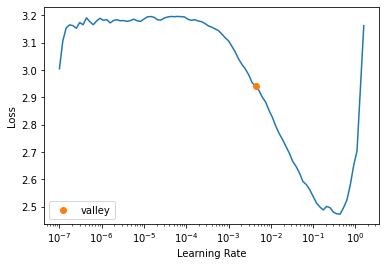

In [15]:
learn = get_learner(dls)
learn.lr_find()

In [16]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.522053,1.345554,0.561521,3.840313,05:05
1,1.315707,1.092473,0.631991,2.981637,05:09
2,1.050113,1.013177,0.678971,2.754338,05:09


Next, we want to use regex to clean some unwanted data. Perhaps we could leave the newline attached, or change it into space if it's not that important. This could be tuned. However, other things we might consider removing them that doesn't really contribute directly to training, such as line separator. 

Here the cleaning is included for some symbols that one sees manually. It's unknown whether there are additional symbols that're present that we don't want to delete. Note we use "delete" (re.sub) rather than "keep" (re.match, etc). They have their own advantage: 
- If we use "keep": we keep what we want. What we're unsure is whether there are things that we want to keep but we aren't aware of. 
- If we use "delete": we delete only what we see. What we aren't sure is whether there are things we want to delete but we aren't aware of. 

So they have their own advantage and their disadvantages. Choose as you please. 

In [17]:
import re

def clean_data(text, include_newline=True):
    text = re.sub("[:<>\t*-]", "", text)
    if include_newline: text = re.sub("\n", " ", text)
    text = text.split("\'")  # .replace("\\", "") doesn't work. 
    text = "'".join(text)
    return text

In [18]:
from tqdm.notebook import tqdm

new_xs_subbed = np.array([clean_data(x) for x in tqdm(new_xs)])
# new_y is unchanged. 

  0%|          | 0/8940 [00:00<?, ?it/s]

In [19]:
dls = numpy_to_pd_to_dls(new_xs, new_y)
dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj try this one on for size . xxmaj i 'd rather not post her name , but if you \n email me , xxmaj i 'll tell you who she is . xxmaj enjoy ! \n\n begin 640 xxunk \n xxup xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk \n xxup xxunk # xxunk \ # xxup xxunk ] xxunk [ # xxup xxunk \ xxup i8 \n xxup xxunk - xxunk # ; xxunk : xxunk xxrep 3 ( xxunk \n m \ < / xxup xxunk \ _ xxunk < xxunk / % \ _ / e \ xxup xxunk ? # xxunk \n xxup m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ \n xxup xxunk / , xxunk =",2
1,"xxbos xxrep 12 - xxmaj part 2 of 14 xxrep 12 - \n xxup m0 . / xxup xxunk / xxup cbn / xxup xxunk / xxup xxunk , xxunk , n- [ \n xxup xxunk \ _ -8 \n xxup my _ / xxup sys * / xxup xxunk \ xxup xxunk > / xxup c^ > / xxup cx_s \ xxup xxunk _ / xxup sc _ . / xxup xxunk _ . / xxup c _ / xxup gcx^ / xxup y _ . / \n m \ xxup x_scx^ / \ _ . / xxup c _ / s \ _ . / \ xxup x^ / \ xxup x^ / xxup cx_scx^ / xxup c _ . / xxup cx^ / \ xxup x^ / xxup c _ . / xxup cx^ / xxup cx^ / \n m \ xxup xxunk _ . / \",2


Actually, we haven't finish cleaning. The reason we make the `DataLoaders` first is we want to know more about the data itself. What are the data after we tokenize it using `SpacyTokenizer`? Some data have lots of `xxunk` (meanings these words aren't available in the dictionary, for whatever reasons like count less than the threshold to put into dictionary, or dictionary already reached max word (60000) specified by `SpacyTokenizer` (default value, can be changed), or other reasons) hence they're not useful. We want to delete these. With this, we can access the tokenizer using `dls.tok`, creating a tokenized text, and from there we can delete those unwanted text. We can also set a `threshold` for deletion. In this case, we use 0.3 for the moment (can be tuned further. 0.3 is just a primitive guess). 

Extra note: you see some other tokenization in the data. E.g. of those that are often seen: (The `xx` is just a signifier, while those characters behind it is the meaning):
- `xxbos`: **b**eginning **o**f **s**entence. 
- `xxeos`: end of sentence. 
- `xxpad`: padding. 
- `xxmaj`: capital letter present in the next word. 

In [20]:
L(dls.vocab[0])

(#39024) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','\n'...]

`L` is a fastai's object. We pass through it because it has the ability to not print everything (unlike Python's list which does that and it's annoying). 

Now, we want to do something we called `stoi` (string to int). We know that the data are arranged such that the position of the vocab corresponds to the actual tokenization. See that in the code below for an example. (`itos` means int to string). 

In [21]:
def itos(vocab, word, join=False, ignore_pad=False): 
    import fastai
    if not isinstance(vocab, np.ndarray): vocab = np.array(vocab)
    if type(word) in [tuple, fastai.text.data.TensorText]: 
        word = np.array(word)
    word = vocab[word]
    if ignore_pad: word = word[word != "xxpad"]
    if join: return " ".join(word)

    return word

In [22]:
example_partial_sentence = dls.train_ds[0][0][:100]
example_partial_sentence, itos(dls.vocab[0], example_partial_sentence, True)

(TensorText([    2,    19,   158,   136,   537,    20,  7537,    14, 12940,    30,
          6814,   622,    12,     9,    19,   158,    11,   862,     8,   745,
             0,    15,    40,  2622,   701,  1371,    17,    15,     0,    20,
             0,   180,    20,  4352,   848,    15,    72,   105,    17,    13,
           180,    32,    33,   186,    12,     9,     8,    63,   898,   332,
            97,    11, 23360,    14,    11,  4384,    46,     8,   701,     8,
          2973,   171,     9,  1013,   375,    14,   411, 12940,    30,    11,
           622,    39,  8715,    38,     9,     8,   113,    19,    72,   105,
            13,   273,  1013,  4730,    41,  8872,    91,     9,  3875,    41,
          7537,    20,    33,   848,    12,     9,    19,    72,    34,   136]),
 'xxbos i am very interested in investigations of starvation for improving health . \n i am the young xxmaj russian xxunk and have highest medical education \n▁ and xxunk in xxunk work in biological field

In [23]:
new_vocab = {key: index for index, key in enumerate(dls.vocab[0])}

In [24]:
new_vocab["xxunk"]

0

But if we use stoi to convert it back, we requires to use `np.where` with each single word, which is very slow. Instead, a key-value dictionary pair speeds up searching, so we need to convert our vocab to such type first (inside our `stoi` for general function). 

In [25]:
def stoi(vocab, word):
    """
    If single word, we will convert it to list. 
    If not single word str, it will make it a list. 
    Then we want the type to be correct, else we raise error. 
    """
    import fastcore

    # Convert array to dict for vocab, if it is
    if type(vocab) in [np.ndarray, list, fastcore.foundation.L]:
        vocab = {key: index for index, key in enumerate(vocab)}

    # type checks and do stoi. 
    if isinstance(word, str): word = word.split(" ")  # convert to list
    if type(word) in [list, tuple, np.ndarray, fastcore.foundation.L]:
        m = np.zeros((len(word), )).astype(np.uint8)
        for k in range(len(word)):
            try: m[k] = vocab[word[k]]
            except KeyError: m[k] = 0  # xxunk assigned, word not in dict. 
        return m
    else: raise NotImplementedError(f"{type(word)} not implemented")

In [26]:
%timeit stoi(new_vocab, "xxunk")

2.07 µs ± 16.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now we can think about creating a tokenized df. WE have a function in fastai for this, where we can pass in the df to tokenize, and the column, and then the tokenizer `dls.tok`. 

In [27]:
df_new_subbed = pd.DataFrame([new_xs_subbed, new_y]).T
df_new_subbed.columns = ["text", "category"]

df_new_toked = tokenize_df(df_new_subbed, "text", n_workers=os.cpu_count(),
                    tok=dls.tok)[0]

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


We take number 0 output, which is the pandas DataFrame we want. Number 1 output is the Counter which contains how many total counts for each occurrence of words, which we don't need. 

In [28]:
df_new_toked.head(2)

,category,text,text_length
0,17,"[xxbos, xxmaj, finally, you, said, what, you, dream, about, ., xxmaj, mediterranean, xxrep, 4, ?, xxmaj, that, was, new, …, ., xxmaj, the, area, will, be, "", greater, "", after, some, years, ,, like, your, "", holocaust, "", numbers, …, …, xxmaj, is't, xxmaj, july, in, xxup, usa, now, xxrep, 5, ?, xxmaj, here, in, xxmaj, sweden, it, 's, xxmaj, april, and, still, cold, ., xxmaj, or, have, you, changed, your, calendar, xxrep, 3, ?, xxup, nothing, xxup, of, xxup, the, xxup, mentioned, xxup, is, xxup, true, ,, xxup, but, xxup, let, xxup, say, it, 's, xxup, true, ., xxup, ...]",384
1,3,"[xxbos, xxmaj, think, !, xxmaj, it, 's, the, xxup, scsi, card, doing, the, xxup, dma, transfers, xxup, not, the, disks, …, xxmaj, the, xxup, scsi, card, can, do, xxup, dma, transfers, containing, data, from, any, of, the, xxup, scsi, devices, it, is, attached, when, it, wants, to, ., xxmaj, an, important, feature, of, xxup, scsi, is, the, ability, to, detach, a, device, ., xxmaj, this, frees, the, xxup, scsi, bus, for, other, devices, ., xxmaj, this, is, typically, used, in, a, multitasking, xxup, os, to, start, transfers, on, several, devices, ., xxmaj, while, each, device, is, seeking, t...",176


Note that here we even have `text_length` which could be used instead to threshold the number of words we want for our sentence. However, this length includes all the special tokens (that starts with `xx`), but you can still use it as threshold irregardless, if you want to. We won't be doing that here. 

In [29]:
choice = np.zeros((len(df_new_toked), )).astype(np.float32)
loop_over = df_new_toked["text"].to_numpy()

for k, data in enumerate(tqdm(loop_over)):
    g = stoi(new_vocab, data)
    choice[k] = (g == 0).sum() / len(g)

  0%|          | 0/8940 [00:00<?, ?it/s]

Actually before we use the dictionary, this thing takes more than 5 minutes to complete just to tokenize. Now looks how long it takes! 

In [30]:
(choice >= 0.3).sum()   # Threshold 30% xxunk have 15 occurrences.

15

Let's look at one of these. 

In [31]:
df_new_subbed[choice >= 0.3]

,text,category
502,"Sterrenkundig symposium 'Compacte Objecten' op 26 april 1993 In het jaar 1643, zeven jaar na de oprichting van de Universiteit van Utrecht, benoemde de universiteit haar eerste sterrenkundige waarnemer. Hiermee ontstond de tweede universiteitssterrenwacht ter wereld. Aert Jansz, de eerste waarnemer, en zijn opvolgers voerden de Utrechtse sterrenkunde in de daaropvolgende jaren, decennia en eeuwen naar de voorhoede van het astronomisch onderzoek. Dit jaar is het 350 jaar geleden dat deze historische benoeming plaatsvond. De huidige generatie U...",14
1093,"Here are the standings after the April 6 update. I'll be leaving for Japan in 1.5 hours, and I won't be back until April 17. Consequently, I will not post the week 27 results until April 18. Email sent between April 13 and April 18 will be processed using the numbers available April 18. Andrew USENET Hockey Draft Standings Week 26 PosnTeamPtsProjCashLast Posn 1.Dave Wessels 14781575.31.9(1) 2.Gilles Carmel 13891533.856.3(5) 3.Bob Hill 14181530.824.0(2) 4.The Awesome Oilers 13661509.968.6(3) 5.Seppo Kemppainen...",10
1314,From Center for Policy Research cpr Subject Poem by Erich Fried Poem by GermanJewish poet Erich Fried (Holocaust survivor) Ein Jude an die zionistischen Kaempfer 1988 von Erich Fried Was wollt ihr eigentlich ? Wollt ihr wirklich die uebertreffen die euch niedergetreten haben vor einem Menschenalter in euer eigenes Blut und in euren eigenen Kot ? Wollt ihr die alten Foltern jetzt an andere weitergeben mit allen blutigen dreckigen Einzelheiten mit allem brutalen Genuss die Folterknechte wie unsere Vaeter sie damals erlitten haben ? Wollt jetzt wirklich ihr die neue ...,17
1758,"Well, I'm back from Tokyo, so here are the standings after the April 13 update. Andrew USENET Hockey Draft Standings Week 27 PosnTeamPtsProjCashLast Posn 1.Dave Wessels 15361572.81.9(1) 2.Bob Hill 14811538.124.0(3) 3.Gilles Carmel 14921529.91.0(2) 4.Seppo Kemppainen 14301514.047.2(5) 5.The Awesome Oilers 14121504.468.6(4) 6.Hillside Raiders 14561495.27.0(7) 7.Mak ""The Knife"" Paranjape 14241491.731.0(6) 8.Jan Stein 14121483.235.3(8) 9.this years model ...",10
4095,Here is the price list for the week April 6 to April 12. Andrew BuySellPtsTeamPlayer 157.5141.8150PITMario_Lemieux 152.1136.9143BUFPat_LaFontaine 139.3125.4131BOSAdam_Oates 133.8120.4129DETSteve_Yzerman 132.9119.6125WPGTeemu_Selanne 132.9119.6125TORDoug_Gilmour 130.9117.8120NYIPierre_Turgeon 129.7116.7122BUFAlexander_Mogilny 126.0113.4117PHIMark_Recchi 120.2108.2113LALuc_Robitaille 115.9104.3109QUEMats_Sundin 111.3100.2106PITKevin_Stevens 108.597.7102STLCraig_Janney 108.597.7102VANPavel_Bure 106.395.7100CHIJeremy_Roenick 105.394.899QUEJoe_Sakic 104.093.699PITRick_Tocchet 103.192.897STLB...,10
5520,"Here are the final stadings for the USENET Hockey Draft. Congratulations to this year's winner, Dave Wessels of Victoria, B.C., who parlayed his initial 1000 points into 1575.9 points! Thanks to all 262 teams for entering the biggest USENET Hockey Draft ever! I hope to hear from you all again this September, for the 7th Annual draft. It has been my pleasure running the draft, and I hope you all had fun. Andrew USENET Hockey Draft Standings Week 28 PosnTeamTotalPtsCashLast Posn 1.Dave Wessels 1575.915741.9(1) 2.Gilles Carmel 1539.015381.0(3) Bob ...",10
5758,"Part 12 of 14 MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX',3$9@L+I5'W]_?W]_?W]_?GIZBJ[N[M7EY7EY7@,#`P,#`P M`P,#`PBHJKN[N[M`P,#`PNRHJBIZ1PMF,8'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'A...",2
6133,"O.K., only one series is done. But I need to post something. 

We have German reports, which just isn't english. Some contains sequences of numbers (and a lot of them) which aren't tokenized as english. We have some that are illegible (not even understandable what it means), and we have some that are specialized for the specific that looks more like representation of position (like the NATIONAL HOCKEY LEAGUE) (8368). Certainly these are the ones we want to remove. 

In [32]:
(choice >= 0.2).sum()  # how much of threshold 20% xxunk? 

49

Then, we need to remove these data, based on our threshold (you can tune this). Make sure you take those **less than** threshold, don't take the wrong subset. 

In [33]:
threshold_del = 0.3
thres = choice < threshold_del
xs_subbed_deleted = new_xs_subbed[thres]
y_subbed_deleted = new_y[thres]

Note that we have two choice now: whether to create a data based on new vocabulary or without using new vocabulary. Here, one chose to create new vocabulary, but you could equally choose not to. 

In [ ]:
clear_cache(True)

In [38]:
dls = numpy_to_pd_to_dls(xs_subbed_deleted, y_subbed_deleted)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [35]:
def num_xxunk(xs, y, dls):
    df_new_subbed = pd.DataFrame([xs, y]).T
    df_new_subbed.columns = ["text", "category"]

    df_new_toked = tokenize_df(df_new_subbed, "text", n_workers=os.cpu_count(),
                        tok=dls.tok)[0]

    choice = np.zeros((len(df_new_toked), )).astype(np.float32)
    loop_over = df_new_toked["text"].to_numpy()

    for k, data in enumerate(tqdm(loop_over)):
        g = stoi(new_vocab, data)
        choice[k] = (g == 0).sum() / len(g)

    del df_new_subbed, df_new_toked, loop_over
    clear_cache()
    return choice

In [36]:
from IPython.display import clear_output
choice = num_xxunk(xs_subbed_deleted, y_subbed_deleted, dls)
clear_output()
print("Threshold 0.3: ", (choice >= 0.3).sum())
print("Threshold 0.2: ", (choice >= 0.2).sum())

Threshold 0.3:  0
Threshold 0.2:  34


With that looking okay, it seems like creating from new still creates a (somewhat similar set of words) vocabulary, that's why we don't have high xxunk anymore (though the vocab might not be totally similar depending on their mappings though, but the words might be the same). 

We can now create a `Learner` to do classification and see how it works. 

## Note
We are doing data cleaning in this notebook, not model training. So the model training tricks will not be used here. We are just wanting to see how things goes. 

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.004365158267319202)

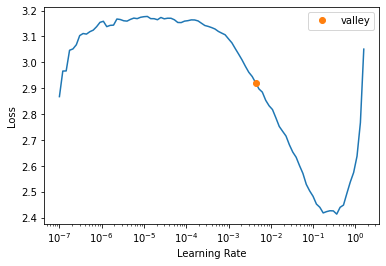

In [39]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()
learn.lr_find()

In [40]:
learn.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.472181,1.185549,0.605381,3.272482,04:32
1,1.301080,1.080424,0.624439,2.945928,04:33
2,1.093660,0.971025,0.672646,2.640648,04:33


What can be tried: perhaps cleaning set `include_newline=False`. 

Starting accuracy is better than baseline. Ending accuracy isn't too much difference (slightly worse) (mostly due to the nature of model and randomness?). Anyway, we can say this is successful cleaning. 